# Anomaly Detection in Time Series data

The package `tsoutliers` detects 5 different types of outliers iteratively in time series data:

- Additive Outlier (AO)
- Innovation Outlier (IO)
- Level Shift (LS)
- Temporary change (TC)
- Seasonal Level Shift (SLS)

[Click here for definition of these outliers](https://www.ibm.com/support/knowledgecenter/SS3RA7_15.0.0/com.ibm.spss.modeler.help/ts_outliers_overview.htm)



In [1]:
library(tsoutliers)
library(expsmooth)
library(fma)

Loading required package: forecast


We will be using historical stock data, contained in `historic_stock_data_table_a.csv`. It has following fields:

- Date – This provides the date as an integer where 20100527 would represent May 27th, 2010.
- Time – This gives the time as an integer where 1426 would represent 2:26PM EST.
- Open – The open price.
- High – The high price.
- Low – The low price.
- Close – The close price.
- Volume – The trading volume during the interval. Note that it is extremely difficult to get accurate volume information. The volume is adjusted for splits so that the total value of shares traded remains constant even if a split occurs.

In [2]:
names=c("Date","Time","Open","High","Low","Close","Volume")
stock = read.csv("/dsa/data/all_datasets/historic_stock_data_table_a.csv",header=FALSE)
names(stock) = names

In [3]:
head(stock)
tail(stock)

Date,Time,Open,High,Low,Close,Volume
19991118,0,42.2076,46.3820,37.4581,39.1928,43981813
19991119,0,39.8329,39.8885,36.9293,37.6251,11390201
19991122,0,38.3208,40.0091,37.1613,39.9442,4654716
19991123,0,39.4247,40.4729,37.3375,37.5138,4268903
19991124,0,37.2262,38.9052,37.1056,38.0889,3602367
19991126,0,37.9219,38.4971,37.8013,38.2095,1332198


,Date,Time,Open,High,Low,Close,Volume
3447,20130802,0,46.06,46.51,46.00,46.36,2183410
3448,20130805,0,46.26,46.40,45.80,45.87,1793270
3449,20130806,0,45.93,46.21,45.61,46.05,2069341
3450,20130807,0,45.88,46.46,45.62,46.30,1491208
3451,20130808,0,46.49,46.55,45.64,45.86,1509067
3452,20130809,0,45.85,46.46,45.81,46.24,1740855


We will use the `ts()` fuction to convert a portion of this data to to a time series. 
Time series are vectors or matrices with class of "ts" (and additional attributes) 
which represent data which has been sampled at equispaced points in time. 
In the matrix case, each column of the matrix data is assumed to contain a single (univariate) time series. 

The ts() function takes parameters for start and end, representing the time of the first and last observations. 
These are not what you would think - they are not actual time values.
They are either single numbers or vectors of two integers which specify a natural time unit and a (1-based) number of samples in that time unit. 
Another parameter is frequency which is the number of observations per unit of time.
So for instance, 
 * `ts(data = someDataVectorOrMatrix, frequency = 4, start = c(2016, 2))` # 2nd Quarter of 2016
 * `ts(data = someDataVectorOrMatrix, frequency = 12, start = c(2016, 1))` # 1st Month of 2016
 * `ts(data = someDataVectorOrMatrix, frequency = 7, start = c(201605, 4))` # 4th day of the fifth week of 2016

Our data is daily, but what is the natural time unit? We will approximate this to a year.
The NYSE and NASDAQ average about 252 trading days a year. 
(Our time series may not exactly have the right number of days per year because of this approximation.) 
The data start with 1999-11-18, which was the 224th trading day of that year.

We will convert the Close column into time series data using the `ts()` function, 
but limit it to just over two years worth of data to keep the data small enough to work with in this notebook. 

In [4]:
help(ts)

In [5]:
stock_series <- ts(stock$Close, start=c(1999,224) , end = c(2000, 224), frequency=252)

In [6]:
stock_series[1:100]

[1]  39.1928  37.6251  39.9442  37.5138  38.0889  38.2095  38.9052  39.1371
  [9]  40.1204  41.5119  41.6881  42.3839  41.9757  41.6881  42.4395  41.9200
 [17]  41.6881  39.0815  38.6733  42.0963  42.6158  43.3115  43.2558  43.4878
 [25]  46.0388  48.9887  56.8179  64.0628  72.8754  71.7158  66.6138  60.8161
 [33]  57.9775  54.5545  60.4172  63.8309  62.9682  61.3448  62.9033  63.4320
 [41]  66.3263  65.6305  63.2001  63.5990  63.4877  62.6713  63.3671  63.6639
 [49]  62.9033  61.3448  66.0387  68.8773  72.1240  70.7325  73.8030  72.7084
 [57]  70.2131  71.0201  69.9812  70.7325  75.3707  75.1388  76.5303  87.3187
 [65]  84.9996  91.8920  98.0979 100.4170  92.6527  95.3150 101.0570  95.8994
 [73] 100.6490 141.3540 128.7100 134.4520 141.4650 132.6530 121.8080 112.7080
 [81] 107.3740 110.6770 112.2440 105.2870 105.5190 110.7420 111.3170 108.4230
 [89] 106.2150 110.5650 103.4320  96.8270  96.4189  90.7325  86.2705  89.4616
 [97]  96.9940 114.0440  98.7936  93.3484

In [7]:
length(stock_series)

[1] 253

In the cell below we are looking for Additive, Level Shift and Temporary Change outliers in data.

In [8]:
stock_outliers <- tso(stock_series,types = c("AO","LS","TC"),maxit.iloop=6)
stock_outliers

Series: stock_series 
Regression with ARIMA(1,0,2) errors 

Coefficients:
         ar1     ma1      ma2  intercept     LS64     TC74     TC98     LS101
      0.9684  0.2447  -0.1938    66.4713  13.3023  38.1685  19.7573  -14.3880
s.e.  0.0181  0.0666   0.0751     7.3123   3.3859   2.9944   3.0811    3.3568
        TC122     LS170
      13.9086  -24.7271
s.e.   3.2432    3.2507

sigma^2 estimated as 12.72:  log likelihood=-677.09
AIC=1376.17   AICc=1377.27   BIC=1415.04

Outliers:
  type ind     time coefhat  tstat
1   LS  64  2000:35   13.30  3.929
2   TC  74  2000:45   38.17 12.747
3   TC  98  2000:69   19.76  6.412
4   LS 101  2000:72  -14.39 -4.286
5   TC 122  2000:93   13.91  4.288
6   LS 170 2000:141  -24.73 -7.607

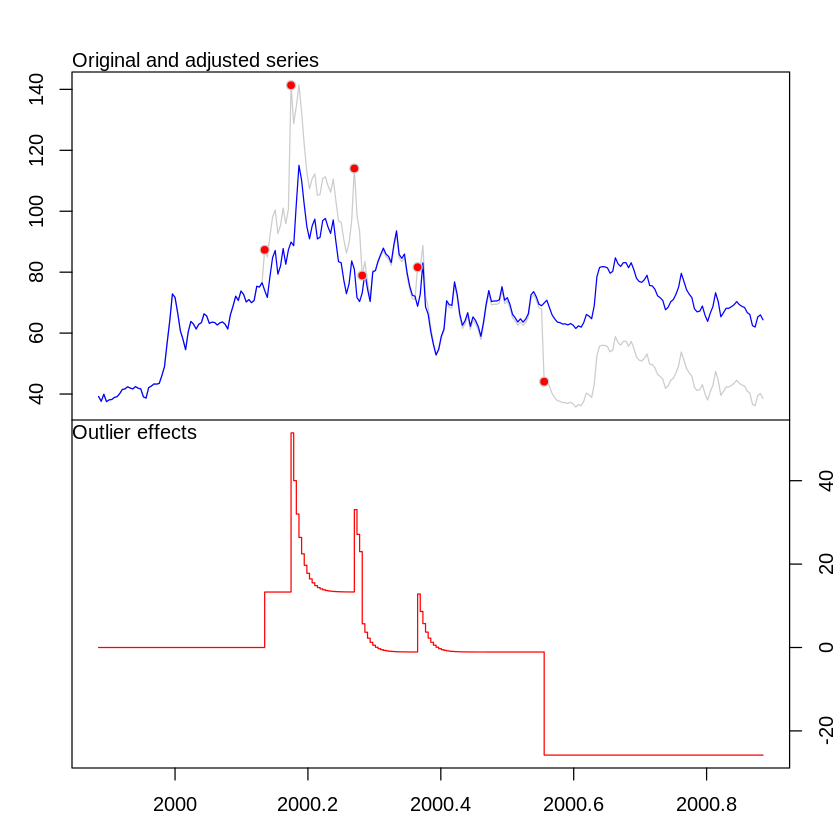

In [9]:
plot(stock_outliers)

The **tso** algorithm detects and adjusts the series for outliers.
In the plot obtained after running the cell above,
the gray line is the original series with outliers, and the blue line is the adjusted series.

In the bottom portion of the plot, different types of outliers are evident by the unit impulse, 
as in this image taken from: [tsoutliers R Package for Detection of Outliers in Time Series](https://web.dsa.missouri.edu/static/PDF/DMIR/tsoutliers.pdf).
![Unit impulse for different types of outliers](../images/tsoutliers.png)

To delve deeper into time series outliers, in addition to the above resource, you can consult the documentation for the _tsoutliers_ package [here](https://cran.r-project.org/web/packages/tsoutliers/tsoutliers.pdf).

## Extra

-----


**Have you used `apply()` before? Here's something similar that does a little more than that** 

- [sweep()](https://www.rdocumentation.org/packages/base/versions/3.4.3/topics/sweep) - or help(sweep).

**Syntax:** sweep(x, MARGIN, STATS, FUN="-", check.margin=T, ...)


**`sweep`** is similar to `apply()` where you apply a function to each column or row of a dataframe. 
But `sweep` is typically used when you operate a matrix by row or by column, 
and need the flexibility for the input of the operation to have a different value for each row / column. 
Whether you operate by row(1) or column(2) is defined by MARGIN, the second parameter in below code. 
So in below piece of code, for each column you will take a value from c(10, 20, 30) which is being defined by STATS parameter and use in the operation "+" defined by FUN parameter.

In [10]:
# Sample code explaining what sweep() is doing
a = c(130,110,118,112,128)
b = c(26,24,25,25,26)
c = c(140,155,142,175,170)
names=c("Weight","Waist","Height")
size = data.frame(a,b,c)
names(size)=names
print(size)

# We are adding values 10, 20, 30 to columns 
sweep(size, 2, c(10, 20, 30), "+")


  Weight Waist Height
1    130    26    140
2    110    24    155
3    118    25    142
4    112    25    175
5    128    26    170


Weight,Waist,Height
140,46,170
120,44,185
128,45,172
122,45,205
138,46,200


--- 